<h1><center>Machine Learning-basierte Extraktion von phänotypischen Kennzahlen aus UAV-Bildern</center></h1>


<h3><center> leaves_counter.ipynb: Zählung der Blättern - Berechnung der Dichte  </center></h3>

Dieses Notebook enthält einen detaillierten Implementierungsrahmen für die Segmentierung von Blättern und die Berechnung der Dichterate in einem Bild. Es beschreibt im Detail die Schritte der Datenorganisation sowie die Trainingsprozesse für das Mask R-CNN-Modell und die Logik hinter der Berechnung der Dichterate.

## Bibliotheken

In [21]:
# Standardbibliotheken für Dateioperationen und Zufallszahlen
import os
import glob as gb
import random

# Externe Bibliotheken für Datenmanipulation und mathematische Operationen
import numpy as np
import pandas as pd

# Bildverarbeitungsbibliotheken zur Bearbeitung und Analyse von Bildern
import cv2
import skimage.feature   

# Visualisierungsbibliotheken für die Erstellung von Grafiken und die Anzeige von Bildern
import seaborn as sns   
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm   
import matplotlib.image as mpimg   
import matplotlib.patches as patches  
from IPython.display import Image, display   
from IPython.display import set_matplotlib_formats  
set_matplotlib_formats("svg")   
from PIL import Image

# Data Science und Machine Learning Bibliotheken für Modellbildung und -evaluation
from sklearn.model_selection import train_test_split   
from sklearn.linear_model import LinearRegression   
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  

# Keras-Bibliothek für Deep Learning Modelle und Schichten
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization  
from keras.optimizers import Adam  
from keras.regularizers import l1_l2  
from keras.callbacks import LearningRateScheduler   

# PyTorch und torchvision für Deep Learning und Bildverarbeitungsaufgaben
import torch
import torchvision
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image

# Zusätzliche Hilfsfunktionen und Operationen für Deep Learning Modelle
import utils   
import torchvision.ops as ops  

# Konfiguration des Geräts für Deep Learning 
device = torch.device("cuda")


/tmp/ipykernel_17921/3055633515.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


## Arbeit

##### Die GrowliFlowerDataset-Klasse ist ein benutzerdefinierter Datensatz-Handler, der für eine nahtlose Integration in die Datenlade- und Verarbeitungsmechanismen von PyTorch entwickelt wurde. Sie ist speziell auf die Verwaltung des GrowliFlower-Datensatzes zugeschnitten und unterstützt Bildsegmentierungsaufgaben zur Extraktion phänotypischer Merkmale.

In [2]:
class GrowliFlowerDataset(torch.utils.data.Dataset):
    # Initialisiert die Dataset-Klasse mit Transformationen und Datensatztyp (Train oder Val).
    def __init__(self, transforms, dataset_type):
        self.transforms = transforms  # Speichert die Transformationen für den Datensatz.
        self.dataset_type = dataset_type  # Speichert den Typ des Datensatzes (Train oder Val).

        # Lädt alle Bilddateien aus dem angegebenen Verzeichnis und sortiert sie zur Ausrichtung.
        self.imgs = list(sorted(os.listdir(f"raid/GrowliFlowerL/images/{self.dataset_type}")))
        # Lädt und sortiert ebenso alle Maskendateien aus ihrem jeweiligen Verzeichnis.
        self.masks = list(sorted(os.listdir(f"raid/GrowliFlowerL/labels/{self.dataset_type}/maskLeaves")))

    # Ruft ein Element aus dem Datensatz am angegebenen Index ab.
    def __getitem__(self, idx):
        # Bestimmt die Pfade für das Bild und die entsprechende Maske basierend auf dem Datensatztyp.
        if self.dataset_type == "Train":
            img_path = os.path.join(f"raid/GrowliFlowerL/images/Train", self.imgs[idx])
            mask_path = os.path.join(f"raid/GrowliFlowerL/labels/Train/maskLeaves", self.masks[idx])
        elif self.dataset_type == "Val":
            img_path = os.path.join(f"raid/GrowliFlowerL/images/Val", self.imgs[idx])
            mask_path = os.path.join(f"raid/GrowliFlowerL/labels/Val/maskLeaves", self.masks[idx])
        
        # Lädt das Bild und die Maske von ihren Pfaden.
        img = read_image(img_path)
        mask = read_image(mask_path)
        
        # Identifiziert eindeutige Objekte in der Maske anhand ihrer kodierten Farben (Hintergrund ausgeschlossen).
        obj_ids = torch.unique(mask)[1:]  # Erster ID (Hintergrund) ausschließen.
        num_objs = len(obj_ids)  # Anzahl der einzigartigen Objekte.

        # Wandelt die farbkodierte Maske in einen Satz binärer Masken um, eine für jedes Objekt.
        masks = mask == obj_ids[:, None, None]
        masks = masks.to(dtype=torch.uint8)

        # Berechnet die Begrenzungsrahmenkoordinaten für die Maske jedes Objekts.
        boxes = masks_to_boxes(masks)

        # Es gibt nur eine Klasse.
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)  # Angenommen, alle Instanzen sind nicht crowd.

        # Verpackt Probe und Ziele in torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    # Gibt die Gesamtanzahl der Bilder im Datensatz zurück.
    def __len__(self):
        return len(self.imgs)


In [3]:
# Modellinstanz für Segmentierung erhalten: Lädt ein vortrainiertes Modell zur Instanzsegmentierung.
def get_model_instance_segmentation(num_classes):
    # Lädt ein auf COCO vortrainiertes Instanzsegmentierungsmodell.
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Ermittelt die Anzahl der Eingabemerkmale für den Klassifikator.
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Ersetzt den vortrainierten Kopf durch einen neuen.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Ermittelt nun die Anzahl der Eingabemerkmale für den Maskenklassifikator.
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Ersetzt den Maskenvorhersager durch einen neuen.
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    # Gibt das modifizierte Modell zurück.
    return model

In [4]:
# Transformationen erhalten: Definiert Bildtransformationen für das Training oder die Evaluation.
def get_transform(train):
    # Initialisiert eine leere Liste für die Transformationen.
    transforms = []
    
    # Wenn es sich um Trainingsdaten handelt, füge zufällige horizontale und vertikale Spiegelungen sowie Farbanpassungen hinzu.
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
        transforms.append(T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1))
    
    # Fügt eine Transformation hinzu, um den Datentyp zu ändern und optional die Daten zu skalieren.
    transforms.append(T.ToDtype(torch.float, scale=True))
    
    # Kombiniert alle hinzugefügten Transformationen in eine zusammengesetzte Transformation.
    return T.Compose(transforms)

##  Training des MASK-R-CNN-Segmentierungsmodells

In [10]:
# Importiert Funktionen zum Trainieren und Evaluieren aus der 'engine'-Datei.
from engine import train_one_epoch, evaluate

# Stellt das Gerät ein, auf dem trainiert werden soll - auf GPU.
device = torch.device('cuda')

# Der Datensatz hat nur zwei Klassen - Hintergrund und Person.
num_classes = 2

# Verwenden des Datensatzes und definierter Transformationen für Trainings- und Validierungsdatensatz.
dataset = GrowliFlowerDataset(get_transform(train=True), dataset_type="Train")
dataset_val = GrowliFlowerDataset(get_transform(train=False), dataset_type="Val")

# Definition der DataLoader für Training und Validierung.
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 16,  # Anzahl der Samples pro Batch
    shuffle = True,  # Zufälliges Mischen der Daten
    num_workers = 8,  # Anzahl der Prozesse zum Laden der Daten
    collate_fn = utils.collate_fn  # Funktion zum Zusammenfügen der Daten
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_val,
    batch_size = 8,  # Kleinere Batch-Größe für die Validierung
    shuffle = False,  # Kein Mischen für die Validierungsdaten
    num_workers = 4,  # Weniger Prozesse für die Validierungsdaten
    collate_fn = utils.collate_fn
)

# Erhalten des Modells mithilfe der get_model_instance_segmentation Funktion.
model = get_model_instance_segmentation(num_classes)

# Verschieben des Modells auf das GPU Gerät.
model.to(device)

# Konstruktion eines Optimierers.
params = [p for p in model.parameters() if p.requires_grad]  # Nur Parameter, die trainiert werden sollen.
optimizer = torch.optim.SGD(
    params,
    lr=0.05,  # Lernrate
    momentum=0.8,  # Momentum für SGD
    weight_decay=0.00005  # Gewichtsverfall zur Regularisierung
)

# Konstruktion eines Lernratenplaners.
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,  # Intervall für die Anpassung der Lernrate
    gamma=0.1  # Faktor der Lernratenanpassung
)

# Training soll für 5 Epochen durchgeführt werden.
num_epochs = 5

for epoch in range(num_epochs):
    try:
        # Trainiert für eine Epoche und druckt alle 10 Iterationen.
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # Aktualisiert die Lernrate.
        lr_scheduler.step()
        # Evaluierung auf dem Testdatensatz.
        evaluate(model, data_loader_test, device=device)
    except Exception as e:
        # Fehlerbehandlung während des Trainings.
        print(f"Fehler während des Trainings aufgetreten: {e}. Ignoriert und setzt das Training fort.")

print("Das ist es!")


Epoch: [0]  [  0/120]  eta: 0:05:26  lr: 0.000470  loss: 4.4309 (4.4309)  loss_classifier: 0.7142 (0.7142)  loss_box_reg: 0.6267 (0.6267)  loss_mask: 2.2245 (2.2245)  loss_objectness: 0.8047 (0.8047)  loss_rpn_box_reg: 0.0609 (0.0609)  time: 2.7230  data: 1.0633  max mem: 16447
Epoch: [0]  [ 10/120]  eta: 0:03:20  lr: 0.004667  loss: 1.9827 (2.5611)  loss_classifier: 0.4385 (0.4734)  loss_box_reg: 0.6452 (0.6371)  loss_mask: 0.6231 (1.0608)  loss_objectness: 0.1421 (0.3406)  loss_rpn_box_reg: 0.0387 (0.0491)  time: 1.8184  data: 0.1293  max mem: 16447
Epoch: [0]  [ 20/120]  eta: 0:02:58  lr: 0.008865  loss: 1.6053 (1.9889)  loss_classifier: 0.3512 (0.3932)  loss_box_reg: 0.6452 (0.6361)  loss_mask: 0.3589 (0.7007)  loss_objectness: 0.1027 (0.2131)  loss_rpn_box_reg: 0.0362 (0.0459)  time: 1.7413  data: 0.0306  max mem: 16786
Epoch: [0]  [ 30/120]  eta: 0:02:39  lr: 0.013062  loss: 1.0983 (1.6841)  loss_classifier: 0.2562 (0.3442)  loss_box_reg: 0.4844 (0.5698)  loss_mask: 0.2769 (0.560

## Inferenz

##### Die folgenden Funktionen sind für die Inferenz wichtig

In [5]:
# Definition einer Funktion, um die zentralste Pflanze in einem Bild zu identifizieren.
def get_central_plant(image_path, size_model_path):
    # Modell laden
    model = get_model_instance_segmentation(2)  # Initialisierung des Segmentierungsmodells mit zwei Klassen
    model.load_state_dict(torch.load(size_model_path))  # Lädt den gespeicherten Modellzustand
    model = model.to(device)  # Verschiebt das Modell auf das entsprechende Gerät (GPU)
    model.eval()  # Schaltet das Modell in den Evaluierungsmodus

    # Bild laden
    image = F.pil_to_tensor(Image.open(image_path))  # Öffnet das Bild und konvertiert es in einen Tensor

    # Bild in Fließkommazahlen konvertieren und auf den Wertebereich [0, 1] normalisieren
    image = image.float() / 255.0

    # Bild auf das gleiche Gerät wie das Modell verschieben
    image = image.to(device)

    # Vorhersagen des Modells erhalten
    with torch.no_grad():  # Deaktiviert die Berechnung von Gradienten für die Vorhersage
        prediction = model([image])

    # Bounding Boxes aus den Vorhersagen extrahieren
    boxes = prediction[0]['boxes']

    # Zentrum jedes Begrenzungsrahmens berechnen
    centers = (boxes[:, :2] + boxes[:, 2:]) / 2  # Mittelpunkt durch Mittelung der Koordinaten

    # Zentrum des Bildes berechnen
    image_center = torch.tensor([image.shape[-2] / 2, image.shape[-1] / 2])  # Mittelpunkt des Bildes
    image_center = image_center.to(device)

    # Distanz jedes Zentrums der Begrenzungsrahmen zum Bildzentrum berechnen
    distances = ((centers - image_center) ** 2).sum(dim=-1).sqrt()  # Euklidische Distanz

    # Bounding Box, der am nächsten zum Zentrum liegt, auswählen
    central_box = boxes[distances.argmin()]  # Index des minimalen Abstands verwenden

    return central_box  # Gibt den zentralsten Bounding Box zurück


In [6]:
# Definition einer Funktion zur Ermittlung der Anzahl der Blätter basierend auf vorhergesagten Bounding Box.
def get_leaves_number(pred_boxes, bbox_data_2d):
    # Initialisierung einer Liste zur Speicherung der Bounding Boxes , die mindestens 90% in einem größeren Rahmen liegen.
    count_leaves = []

    # Durchlaufen jedes kleineren Bounding Box
    for box in pred_boxes:
        # Berechnung der Koordinaten des Schnittbereichs mit dem größeren Rahmen
        x1 = max(box[0], bbox_data_2d[0][0])  # Linke obere Ecke
        y1 = max(box[1], bbox_data_2d[0][1])  # Linke obere Ecke
        x2 = min(box[2], bbox_data_2d[0][2])  # Rechte untere Ecke
        y2 = min(box[3], bbox_data_2d[0][3])  # Rechte untere Ecke

        # Berechnung der Fläche des Schnittbereichs
        intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

        # Berechnung der Fläche der kleineren Box
        box_area = (box[2] - box[0]) * (box[3] - box[1])

        # Wenn die Fläche des Schnittbereichs mindestens 90% der Fläche des kleineren Rahmens entspricht
        if intersection_area >= 0.9 * box_area:
            # Hinzufügen des Rahmens zur Liste
            count_leaves.append(box)

    # Rückgabe der Anzahl der Blätter (Anzahl der Bounding Boxes in der Liste)
    return len(count_leaves)


In [7]:
def plot_leaves(image_path):
    PATH_model = 'models/leaves_segmentation/model15.pth'
    size_model_path = 'models/plant_segmentation/model10.pth'
    # Load the model
    model = get_model_instance_segmentation(2)
    model.load_state_dict(torch.load(PATH_model))
    model = model.to(device) 
    model.eval()
    eval_transform = get_transform(train=False)

    bbox_data = get_central_plant(image_path, size_model_path) 
    bbox_data_2d = bbox_data.unsqueeze(0)   
    # Read and preprocess the image
    image = read_image(image_path)
    with torch.no_grad():
        x = eval_transform(image)
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]

    # Filter predictions based on score
    pred_scores = pred["scores"]
    keep = pred_scores > 0.8
    pred_labels = pred["labels"][keep]
    pred_scores = pred_scores[keep]
    pred_boxes = pred["boxes"][keep]
    pred_masks = pred["masks"][keep]

    # Get the number of boxes
    num_boxes_leaves = len(pred_boxes)
    print(f"Number of leaves detected: {num_boxes_leaves}")

    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]
    pred_labels = [f"leaves: {score:.3f}" for label, score in zip(pred_labels, pred_scores)]

    # Draw the bounding boxes for the leaves
    output_image = draw_bounding_boxes(image, pred_boxes.long(), pred_labels, colors="red")
    # Draw the bounding box for the plant
    #output_image = draw_bounding_boxes(output_image, bbox_data_2d.long(), colors="blue")
    #Get the number of leaves inside the plant
    leaves_number = get_leaves_number(pred_boxes, bbox_data_2d)
    print(f"Number of leaves inside the plant: {leaves_number}")

    masks = (pred_masks > 0.7).squeeze(1)

    # Generate a list of colors
    colors = cm.rainbow(np.linspace(0, 1, num_boxes_leaves))  # replace num_plants with num_boxes

    # Convert RGBA to hexadecimal
    colors = [matplotlib.colors.to_hex(color) for color in colors]

    # Draw the segmentation masks
    output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors=colors)

    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(output_image.permute(1, 2, 0))

### Plotten aller erkannten Blätter in einem Bild

Number of leaves detected: 22
Number of leaves inside the plant: 10


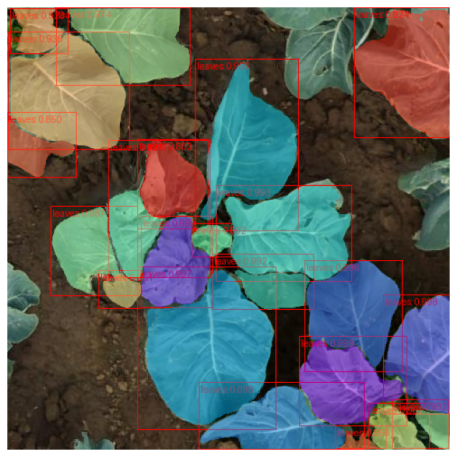

In [10]:
image_path ='raid/GrowliFlowerO/Field1/2020_08_25/2020_08_25_Ref_Plot1_A7.jpg'
image_path ='raid/GrowliFlowerO/Field1/2020_09_08/2020_09_08_Ref_Plot4_C91.jpg'
#image_path ='raid/GrowliFlowerO/Field1/2020_08_25/2020_08_25_Ref_Plot1_C90.jpg'

plot_leaves(image_path)

### Plotten der Blätter und der Pflanzboxen und Erhalten der Anzahl der Blätter innerhalb der Pflanzenbox

In [22]:
def plot_plant_leaves_boxes(image_path, PATH_model, size_model_path):
    # Definieren der Transformationsfunktion für die Evaluierung
    eval_transform = get_transform(train=False)
    num_classes = 2

    # Laden des Modells für die Segmentierung der Blätter
    model = get_model_instance_segmentation(num_classes)
    model.load_state_dict(torch.load(PATH_model))
    model = model.to(device) 
    model.eval()

    # Extrahieren der zentralen Pflanze aus dem Bild
    bbox_data = get_central_plant(image_path, size_model_path)
    bbox_data_2d = bbox_data.unsqueeze(0)

    # Lesen des Bildes und Anwenden der Transformation
    image = read_image(image_path)
    with torch.no_grad():
        x = eval_transform(image)
        # Konvertieren von RGBA zu RGB und Verschieben auf das Gerät
        x = x[:3, ...].to(device)
        predictions = model([x, ])

    # Filtern der Vorhersagen basierend auf dem Score
    pred = predictions[0]
    pred_scores = pred["scores"]
    keep = pred_scores > 0.8
    pred_labels = pred["labels"][keep]
    pred_scores = pred_scores[keep]
    pred_boxes = pred["boxes"][keep]
    pred_masks = pred["masks"][keep]

    # Anzahl der erkannten Blätter ermitteln
    num_boxes_leaves = len(pred_boxes)
    print(f"Anzahl der erkannten Blätter: {num_boxes_leaves}")

    # Bildnormalisierung und Konvertierung zu uint8
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]
    pred_labels = [f"Blätter: {score:.3f}" for label, score in zip(pred_labels, pred_scores)]

    # Zeichnen der Bounding Boxes für die Blätter
    output_image = draw_bounding_boxes(image, pred_boxes.long(), pred_labels, colors="red")
    # Zeichnen des Bounding Box für die Pflanze
    output_image = draw_bounding_boxes(output_image, bbox_data_2d.long(), colors="blue")

    # Anzahl der Blätter innerhalb der Pflanze ermitteln
    leaves_number = get_leaves_number(pred_boxes, bbox_data_2d)
    print(f"Anzahl der Blätter innerhalb der Pflanze: {leaves_number}")

    # Erzeugen der Segmentierungsmasken
    masks = (pred_masks > 0.7).squeeze(1)

    # Generieren einer Liste von Farben
    colors = cm.rainbow(np.linspace(0, 1, num_boxes_leaves))

    # Konvertieren von RGBA zu Hexadezimal
    colors = [matplotlib.colors.to_hex(color) for color in colors]

    # Zeichnen der Segmentierungsmasken
    output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors=colors)

    # Anzeigen des Bildes
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(output_image.permute(1, 2, 0))


Anzahl der erkannten Blätter: 22
Anzahl der Blätter innerhalb der Pflanze: 10


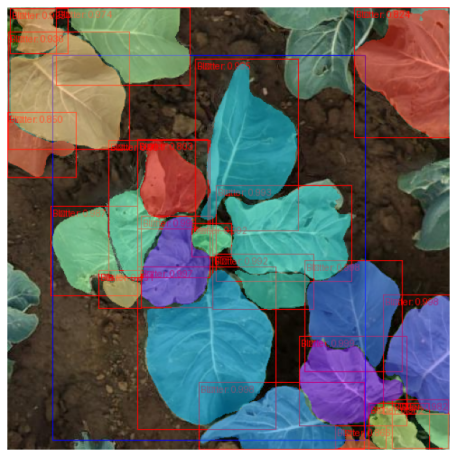

In [23]:
plot_plant_leaves_boxes(image_path, 'models/leaves_segmentation/model15.pth', 'models/plant_segmentation/model18.pth')

### RGB-Masken zeichnen

##### Der Zweck dieser Funktion ist es, eine Maske von Pflanzen zu zeichnen, die den im GrowliFlowerL-Datensatz vorhandenen ähnlich sind. Sie kann bei der Erweiterung dieses Datensatzes von Nutzen sein.

In [13]:
def mask_segmentation(image_path , PATH_model):
    num_classes = 2
    model = get_model_instance_segmentation(num_classes)
    model.load_state_dict(torch.load(PATH_model))
    model = model.to(device) 
    model.eval()
    image = read_image(image_path)
    with torch.no_grad():
        x = eval_transform(image)
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]

    # Filter predictions based on score
    pred_scores = pred["scores"]
    keep = pred_scores > 0.8
    pred_labels = pred["labels"][keep]
    pred_scores = pred_scores[keep]
    pred_boxes = pred["boxes"][keep]
    pred_masks = pred["masks"][keep]

    # Get the number of boxes
    num_boxes = len(pred_boxes)
    print(f"Number of plants detected: {num_boxes}")

    _, h, w = pred_masks.shape[-3:]

    # Create a solid blue background image with RGBA (62,38,168,255)
    blue_background = torch.zeros((3, h, w), dtype=torch.uint8)
    blue_background[0].fill_(62)    # Red channel
    blue_background[1].fill_(38)    # Green channel
    blue_background[2].fill_(168)   # Blue channel

    masks = (pred_masks > 0.7).squeeze(1)

    # Generate a list of solid colors for each mask or use a single solid color for all
    colors = cm.rainbow(np.linspace(0, 1, num_boxes))
    colors = [matplotlib.colors.to_hex(color) for color in colors]

    #output_image = draw_bounding_boxes(output_image, pred_boxes.long(), pred_labels, colors="red")
    output_image = draw_segmentation_masks(blue_background, masks, alpha=1.0, colors=colors)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(to_pil_image(output_image))
    plt.show()


Number of plants detected: 6


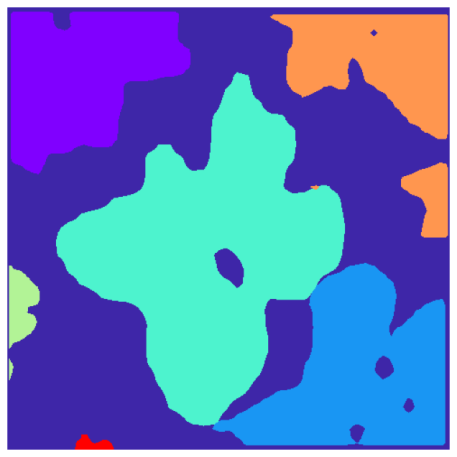

In [17]:
#image_path ='raid/GrowliFlowerO/Field1/2020_08_25/2020_08_25_Ref_Plot1_C90.jpg'
PATH_model = 'models/plant_segmentation/model18.pth'
mask_segmentation(image_path , PATH_model)

## Berechnung der Dichtrate

In [24]:
def extract_float_value(x):
    if isinstance(x, torch.Tensor):
        return x.item()
    elif isinstance(x, int):
        return float(x)
    else:
        return x

In [33]:
# Blattanzahl zählen: Zählt die Blätter einer Pflanze und berechnet die Dichte.
def get_density_rate(image_path):
    # Pfade zu den Modellen für die Segmentierung der Blätter und der Pflanze.
    model_path = 'models/leaves_segmentation/model15.pth' #Blätter
    size_model_path = 'models/plant_segmentation/model17.pth' #Pflanze
    # Anzahl der Klassen 
    num_classes = 2
    # Transformationsfunktion für die Evaluierung vorbereiten, nicht fuer das Training.
    eval_transform = get_transform(train=False)

    # Ermittelt den zentralen Pflanzenbereich im Bild.
    bbox_data = get_central_plant(image_path, size_model_path)
    # Weist bbox_data einen Standardwert zu, falls kein Bereich ermittelt wurde.
    if torch.all(bbox_data == 0):
        bbox_data = torch.zeros(1, 4)

    # Lädt das Modell für die Instanzsegmentierung.
    model = get_model_instance_segmentation(num_classes)
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()

    # Bereitet die Daten des Bounding-Box für die Verarbeitung vor.
    bbox_data_2d = bbox_data.unsqueeze(0)

    # Lädt das Bild und wendet die Transformation an.
    image = read_image(image_path)
    with torch.no_grad():
        x = eval_transform(image)
        x = x[:3, ...].to(device)
        predictions = model([x, ])
        pred = predictions[0]

    # Filtert die Vorhersagen basierend auf einem Schwellenwert (80%).
    pred_scores = pred["scores"]
    keep = pred_scores > 0.8
    pred_labels = pred["labels"][keep]
    pred_scores = pred_scores[keep]
    pred_boxes = pred["boxes"][keep]
    pred_masks = pred["masks"][keep]

    # Zählt die erkannten Blätter.
    num_boxes_leaves = len(pred_boxes)

    # Bereitet das Bild für die Anzeige vor.
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
    image = image[:3, ...]
    pred_labels = [f"Blätter: {score:.3f}" for label, score in zip(pred_labels, pred_scores)]

    # Zeichnet das Bounding-Box um die erkannten Blätter.
    output_image = draw_bounding_boxes(image, pred_boxes.long(), pred_labels, colors="red")
    
    # Zeichnet ein Bounding-Box um die zentrale Pflanze, wenn die Daten korrekt sind.
    if bbox_data_2d.shape[1] >= 4: 
        leaves_number = get_leaves_number(pred_boxes, bbox_data_2d)
    else:
        print(f"Warning: bbox_data_2d für das Bild {image_path} hat nicht die erwartete Form. Bounding-Box werden übersprungen.")
        leaves_number = 0

    # Berechnet und zeichnet Segmentation-Masken für die Blätter.
    masks = (pred_masks > 0.7).squeeze(1)
    colors = cm.rainbow(np.linspace(0, 1, num_boxes_leaves))
    colors = [matplotlib.colors.to_hex(color) for color in colors] 
    
    #### Dichtrateberechnung

    # Berechnet die Fläche jeder Maske durch Summierung aller Pixel in der Maske.
    mask_areas = pred_masks.sum(dim=[1, 2])
    total_mask_area = mask_areas.sum()
    
    # Berechnet die Gesamtfläche des Bildes.
    total_image_area = image.shape[1] * image.shape[2]
    
    # Berechnet den Prozentsatz der Bildfläche, den die Masken einnehmen.
    percentage = (total_mask_area / total_image_area) * 100
    print(f"Die Masken nehmen {percentage:.2f}% der Bildfläche ein.")
    density = num_boxes_leaves * percentage 
    print(f"Die Dichterate der Pflanzen im Bild beträgt {density / 10}")

    density = extract_float_value(density) # Float-Wert extrahieren: Konvertiert das density-Wert in einen Float.
 
    
    return output_image, num_boxes_leaves, leaves_number, density

In [34]:
output_image, num_boxes_leaves, leaves_number, density = get_density_rate(image_path)

Die Masken nehmen 58.70% der Bildfläche ein.
Die Dichterate der Pflanzen im Bild beträgt 129.12960815429688


: 

----------------------------------

#### Hinweis: Die automatisch generierten Dateien können beim Training des Modells Probleme verursachen. Wenn dies der Fall ist, sollten sie mit den folgenden Befehlen entfernt werden

In [1]:
rm -r raid/GrowliFlowerL/labels/Train/maskPlants/.ipynb_checkpoints
rm -r raid/GrowliFlowerL/labels/Train/maskLeaves/.ipynb_checkpoints
rm -r raid/GrowliFlowerL/images/Train/.ipynb_checkpoints
rm -r raid/GrowliFlowerO/Field1/.DS_Store

rm: cannot remove 'raid/GrowliFlowerL/labels/Train/maskPlants/.ipynb_checkpoints': No such file or directory
